# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup as soup # HTML parser

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [105]:
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [106]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [107]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(74, 6)


,title,price,year,link,brand,age
0,2012 hyundai veloster,2500,2012.0,https://charlottesville.craigslist.org/cto/d/s...,missing,13.0
1,2003 honda pilot,1500,2003.0,https://charlottesville.craigslist.org/cto/d/c...,honda,22.0
2,clean,3000,NaN,https://charlottesville.craigslist.org/cto/d/c...,missing,NaN
3,2016 bmw x3 28d,14230,2016.0,https://charlottesville.craigslist.org/cto/d/c...,bmw,9.0
4,2006 volvo s60 2.5t,4285,2006.0,https://charlottesville.craigslist.org/cto/d/c...,volvo,19.0


With the data in and wrangled, we can now do some analysis:

count       74.000000
mean     11468.283784
std      13605.849512
min       1000.000000
25%       3500.000000
50%       6725.000000
75%      13375.000000
max      79999.000000
Name: price, dtype: float64


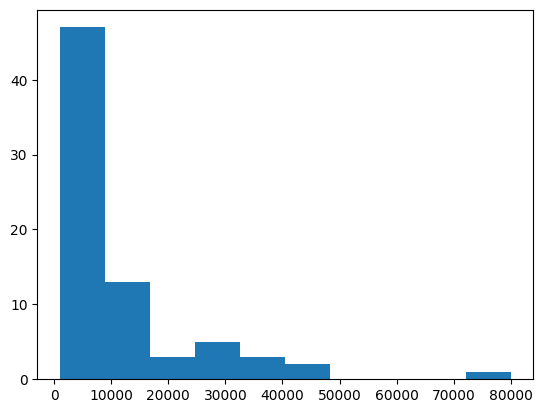

count    65.000000
mean     16.584615
std      11.101650
min       2.000000
25%      11.000000
50%      14.000000
75%      19.000000
max      62.000000
Name: age, dtype: float64


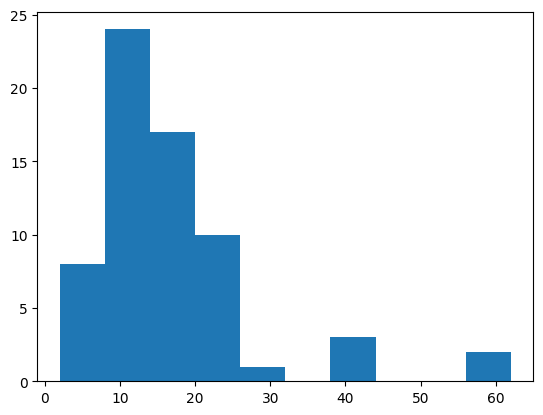

In [108]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [109]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
audi         1.0  46500.000000           NaN  46500.0  46500.00  46500.0   
bmw          3.0  13743.333333   3029.460898  10500.0  12365.00  14230.0   
chevrolet    2.0   6750.000000   4596.194078   3500.0   5125.00   6750.0   
chevy        4.0  12612.250000  10886.859063   2999.0   3712.25  11225.0   
dodge        3.0  21333.333333  16289.055630  10000.0  12000.00  14000.0   
ford         6.0  12200.000000  12465.151423   1200.0   2250.00   7750.0   
honda        7.0   5114.285714   2391.776586   1500.0   4000.00   4900.0   
jeep         4.0   8312.500000   5436.661813   3250.0   5687.50   7000.0   
kia          1.0   1250.000000           NaN   1250.0   1250.00   1250.0   
lexus        1.0  28500.000000           NaN  28500.0  28500.00  28500.0   
mazda        1.0   1000.000000           NaN   1000.0   1000.00   1000.0   
missing     24.0  12874.541667  18615.822333   1000.0   2875.00   5250.0   
mitsubishi   1.0   5800.000000           NaN   5800.0   5800.00   5800.0   
porsche      1.0  23900.000000           NaN  23900.0  23900.00  23900.0   
subaru       4.0   5975.000000   4139.343748   2000.0   2900.00   5475.0   
toyota       8.0  10275.000000  10372.869833   2500.0   6350.00   7450.0   
volkswagen   2.0   5450.000000   2899.137803   3400.0   4425.00   5450.0   
volvo        1.0   4285.000000           NaN   4285.0   4285.00   4285.0   

                              
                75%      max  
brand                         
audi        46500.0  46500.0  
bmw         15365.0  16500.0  
chevrolet    8375.0  10000.0  
chevy       20125.0  25000.0  
dodge       27000.0  40000.0  
ford        21500.0  30000.0  
honda        6225.0   8950.0  
jeep         9625.0  16000.0  
kia          1250.0   1250.0  
lexus       28500.0  28500.0  
mazda        1000.0   1000.0  
missing     12375.0  79999.0  
mitsubishi   5800.0   5800.0  
porsche     23900.0  23900.0  
subaru       8550.0  10950.0  
toyota       8225.0  35500.0  
volkswagen   6475.0   7500.0  
volvo        4285.0   4285.0

In [110]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
audi         1.0   2.000000        NaN   2.0   2.00   2.0   2.00   2.0
bmw          3.0  13.000000   6.928203   9.0   9.00   9.0  15.00  21.0
chevrolet    1.0  11.000000        NaN  11.0  11.00  11.0  11.00  11.0
chevy        4.0  22.000000  12.569805   9.0  15.75  20.0  26.25  39.0
dodge        3.0  20.666667  18.502252   9.0  10.00  11.0  26.50  42.0
ford         6.0  13.166667   8.658329   4.0   5.25  13.0  20.75  23.0
honda        7.0  16.000000   4.690416  10.0  12.50  15.0  20.00  22.0
jeep         4.0  25.500000  10.878113  17.0  18.50  22.0  29.00  41.0
kia          0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
lexus        1.0   5.000000        NaN   5.0   5.00   5.0   5.00   5.0
mazda        1.0  14.000000        NaN  14.0  14.00  14.0  14.00  14.0
missing     18.0  17.611111  15.770930   5.0  10.25  13.0  17.00  62.0
mitsubishi   1.0  23.000000        NaN  23.0  23.00  23.0  23.00  23.0
porsche      1.0  12.000000        NaN  12.0  12.00  12.0  12.00  12.0
subaru       4.0  16.250000   7.228416  12.0  12.00  13.0  17.25  27.0
toyota       7.0  14.000000   6.557439   3.0  12.00  15.0  15.50  25.0
volkswagen   2.0  15.000000   2.828427  13.0  14.00  15.0  16.00  17.0
volvo        1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0

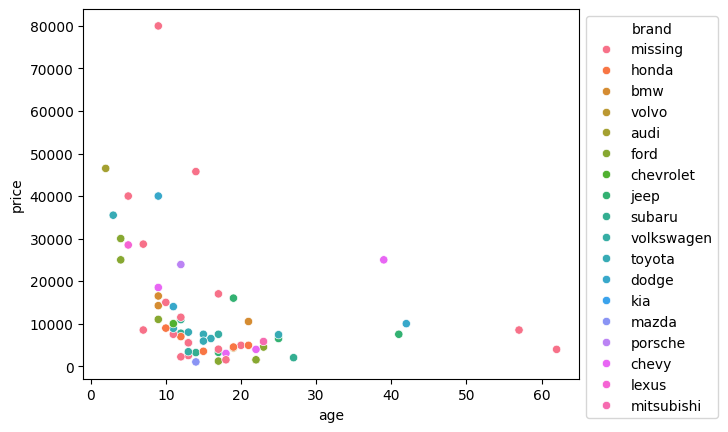

In [111]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   1.022454 -0.320191
log_age    -0.320191  0.391573
           log_price   log_age
log_price   1.000000 -0.526107
log_age    -0.526107  1.000000


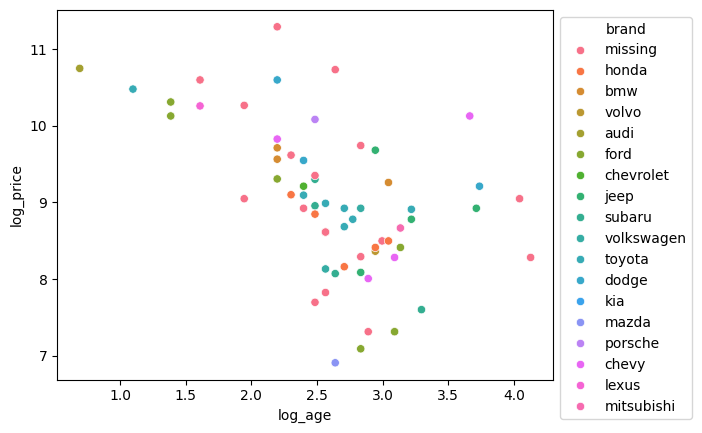

In [112]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

## 1.
We're looking at the Motorcycles craigslist page and the fields of data we would collect would be Price, Year Produced, Brand, Odometer (miles driven), Type, and Location. We could leverage this data to explore the following EDA relationships:
* What is the distribution of motorcycle types in the Charlottesville area?
* How does a motorcycle's type affect its price?
* How does a motorcycle's age affect its listing price, if at all?
* What is the relationship between a motorcycle's milage and listing price?
* Which motorcycle brands remain high value, in spite of their milage/age?


## 2.

In [113]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/mca?purveyor=owner#search=2~gallery~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [114]:
# i stole this from before
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result")

In [115]:
# ok here's the general idea; it's not enough to just read from the static page cause it's too little info.
# i'm instead going to get the links to each listing and then parse the data THERE because there's a lot more info to work with!
links_to_visit = []
# df instantiation for later
motorcycle_df = pd.DataFrame(columns=['year', 'make_model', 'motorcycle_type', 'odometer_reading', 'price'])
# looping through the listings to grab the links
for listing in listings:
    links_to_visit.append(listing.find('a').attrs['href'])

# now we actually visit them
for link in links_to_visit:
    raw = requests.get(link, headers=header)
    bsObj = soup(raw.content,'html.parser')
    # grab the make-model and year data with this class
    make_model_div = bsObj.find_all(class_='attr important')
    # if there's no data in the resultset it's just missing
    if len(make_model_div) == 0:
        year = 'missing'
        make_model = 'missing'
    else:
        year = make_model_div[0].contents[1].get_text()
        make_model = make_model_div[0].contents[3].get_text()
    # repeat with grabbing the motorcycle type
    type_div = bsObj.find_all(class_='attr motorcycle_type')
    if len(type_div) == 0:
        motorcycle_type = 'missing'
    else:
        motorcycle_type = type_div[0].contents[3].get_text()
    # repeat with grabbing the odometer reading
    odometer_div = bsObj.find_all(class_='attr auto_miles')
    if len(odometer_div) == 0:
        odometer_reading = 'missing'
    else:
        odometer_reading = odometer_div[0].contents[3].get_text()
    # lastly grab the price
    price_div = bsObj.find_all(class_='price')
    if len(price_div) == 0:
        price = 'missing'
    else:
        price = price_div[0].get_text()
    # this was absolutely disgusting to write and I hate my life
    motorcycle_df = pd.concat([motorcycle_df, pd.DataFrame({'year': [year], 
                                                            'make_model': [make_model], 
                                                            'motorcycle_type': [motorcycle_type], 
                                                            'odometer_reading': [odometer_reading], 
                                                            'price': [price]})], ignore_index=True)

## 3.

In [116]:
motorcycle_df.head()

,year,make_model,motorcycle_type,odometer_reading,price
0,2003,Victory Kingpin\n,cruiser\n,876,"$4,750"
1,,ducati scrambler\n,standard\n,"11,490","$4,899"
2,,yamaha v star 1100\n,cruiser\n,"2,300","$3,500"
3,2020,Zero FXS ZF7.2\n,standard\n,"4,042","$5,800"
4,2013,yamaha vstar 650\n,cruiser\n,"3,100","$2,800"


In [117]:
import re # Regular expressions

brands = ['honda', 'kawasaki', 'triumph', 'yamaha', 'bmw', 'harley', 'h-d', 'victory']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [118]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(14, 6)


,title,price,year,link,brand,age
0,2003 victory v92c cruiser motorcycle super low...,4750,2003.0,https://charlottesville.craigslist.org/mcy/d/s...,victory,22.0
1,ducati scrambler icon 2015 803cc,4899,2015.0,https://charlottesville.craigslist.org/mcy/d/c...,missing,10.0
2,1999. yamaha1100 vstar,3500,1999.0,https://charlottesville.craigslist.org/mcy/d/b...,missing,26.0
3,zero fxs zf7.2,5800,NaN,https://charlottesville.craigslist.org/mcy/d/c...,missing,NaN
4,2013 650 black yamaha vstar,2800,2013.0,https://charlottesville.craigslist.org/mcy/d/l...,yamaha,12.0


count      14.000000
mean     3381.357143
std      2552.475951
min         0.000000
25%       875.000000
50%      3500.000000
75%      5349.750000
max      8000.000000
Name: price, dtype: float64


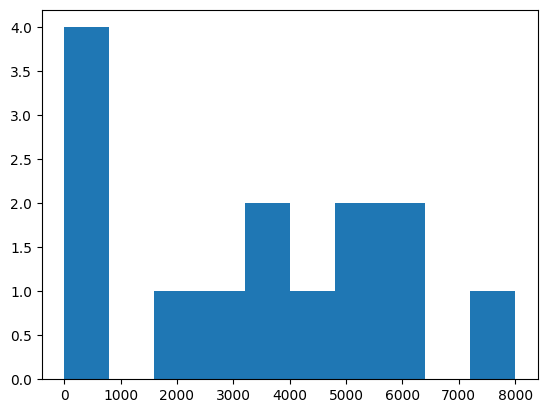

count     9.000000
mean     24.333333
std      14.645819
min      10.000000
25%      14.000000
50%      22.000000
75%      26.000000
max      57.000000
Name: age, dtype: float64


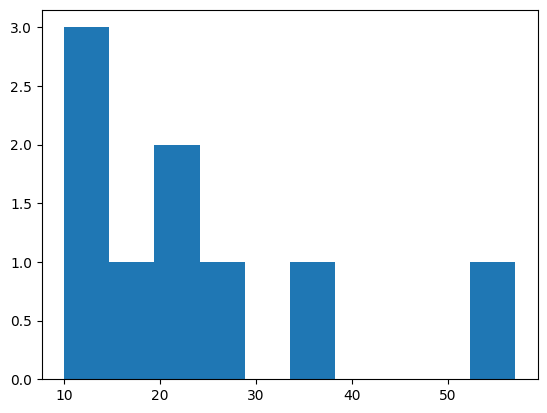

In [119]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [120]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                            \
        count         mean          std     min     25%     50%     75%   
brand                                                                     
bmw       1.0  5800.000000          NaN  5800.0  5800.0  5800.0  5800.0   
h-d       1.0  5500.000000          NaN  5500.0  5500.0  5500.0  5500.0   
harley    1.0  8000.000000          NaN  8000.0  8000.0  8000.0  8000.0   
honda     1.0  2000.000000          NaN  2000.0  2000.0  2000.0  2000.0   
missing   7.0  2641.285714  2367.824931     0.0   395.0  3500.0  4199.5   
triumph   1.0     0.000000          NaN     0.0     0.0     0.0     0.0   
victory   1.0  4750.000000          NaN  4750.0  4750.0  4750.0  4750.0   
yamaha    1.0  2800.000000          NaN  2800.0  2800.0  2800.0  2800.0   

                 
            max  
brand            
bmw      5800.0  
h-d      5500.0  
harley   8000.0  
honda    2000.0  
missing  5800.0  
triumph     0.0  
victory  4750.0  
yamaha   2800.0

In [121]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                               
        count  mean        std   min   25%   50%   75%   max
brand                                                       
bmw       1.0  14.0        NaN  14.0  14.0  14.0  14.0  14.0
h-d       1.0  24.0        NaN  24.0  24.0  24.0  24.0  24.0
harley    1.0  18.0        NaN  18.0  18.0  18.0  18.0  18.0
honda     1.0  36.0        NaN  36.0  36.0  36.0  36.0  36.0
missing   2.0  18.0  11.313708  10.0  14.0  18.0  22.0  26.0
triumph   1.0  57.0        NaN  57.0  57.0  57.0  57.0  57.0
victory   1.0  22.0        NaN  22.0  22.0  22.0  22.0  22.0
yamaha    1.0  12.0        NaN  12.0  12.0  12.0  12.0  12.0

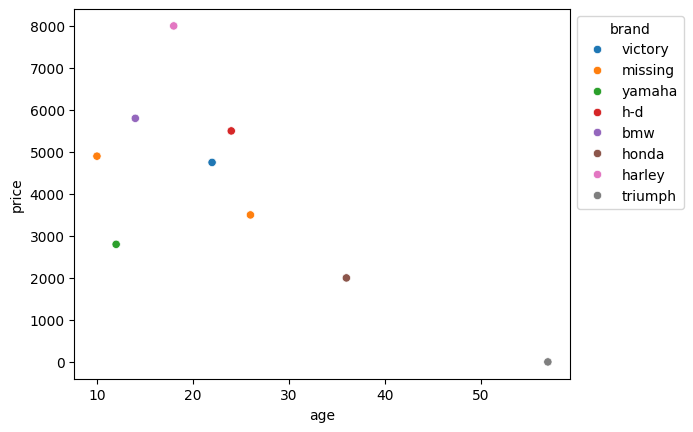

In [122]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   1.047320 -0.070465
log_age    -0.070465  0.300556
           log_price   log_age
log_price   1.000000 -0.368938
log_age    -0.368938  1.000000


C:\Users\jonha\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


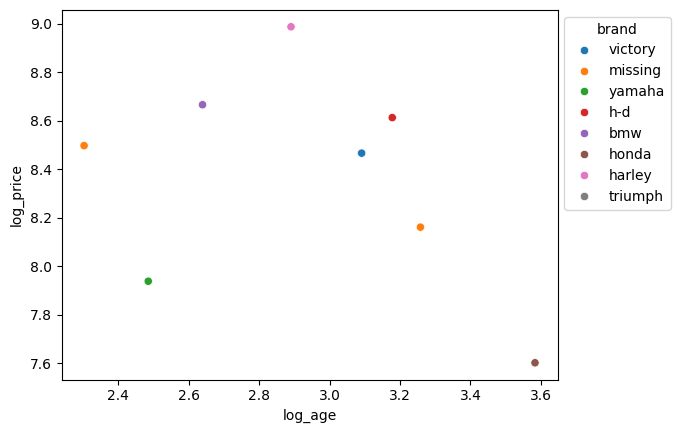

In [123]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

### What is the distribution of motorcycle types in the Charlottesville area?
To explore this question, we create a simple histogram using seaborn to analyze the different motorcycle types sold in the area:

([0, 1, 2, 3, 4],
 [Text(0, 0, 'cruiser'),
  Text(1, 0, 'standard'),
  Text(2, 0, 'scooter/moped'),
  Text(3, 0, 'touring'),
  Text(4, 0, 'sport touring')])

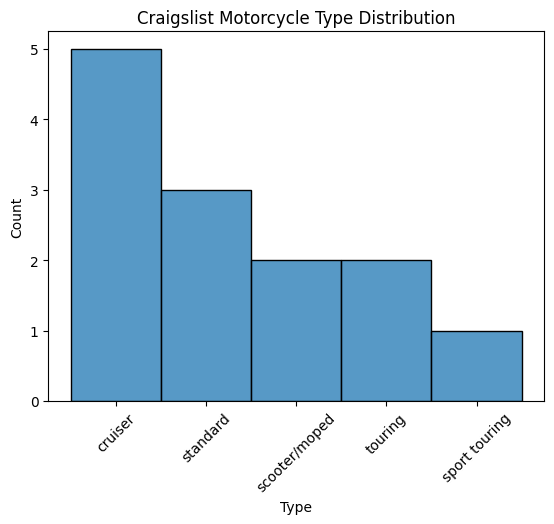

In [124]:
motorcycle_df["cleaned_motorcycle_type"] = motorcycle_df["motorcycle_type"].str.strip()
# ignore missing values in histogram
motorcycle_df["cleaned_motorcycle_type"] = motorcycle_df["cleaned_motorcycle_type"].replace("missing", np.nan)

fig = sns.histplot(motorcycle_df["cleaned_motorcycle_type"])
fig.set(title='Craigslist Motorcycle Type Distribution',
xlabel='Type', 
ylabel='Count')
plt.xticks(rotation=45)

From the generated historgram, cruisers seem to be the most popular type of motorcycle for sale in the Charlottesville area, followed by standard motorcycles, scooter/mopeds, touring motorcycles, and sport touring motorcycles. But why are cruisers specifically so popular?

### How does a motorcycle's type affect its price?
One direction of thought is that if cruisers are most popularly sold, there may exist a relationship between a motorcycle's type and its listing price. To analyze this, we can create a stripplot of each listing's type and pricepoints.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'cruiser'),
  Text(1, 0, 'standard'),
  Text(2, 0, 'scooter/moped'),
  Text(3, 0, 'touring'),
  Text(4, 0, 'sport touring')])

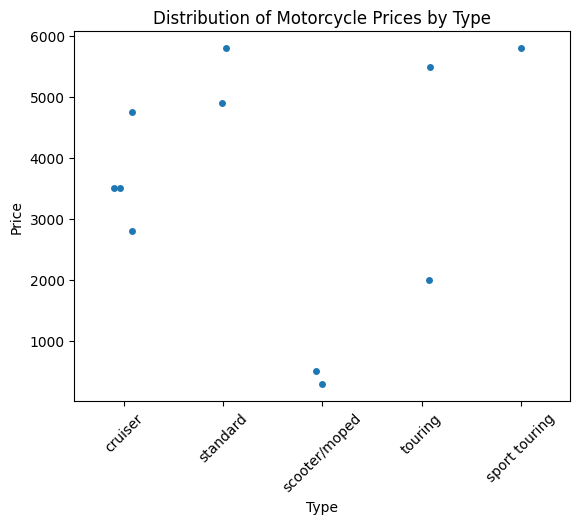

In [125]:
motorcycle_df["cleaned_price"] = motorcycle_df["price"].str.replace("$", "")
motorcycle_df["cleaned_price"] = motorcycle_df["cleaned_price"].str.replace(",", "")
motorcycle_df["cleaned_price"] = pd.to_numeric(motorcycle_df["cleaned_price"], errors="coerce")

x_var = "cleaned_motorcycle_type"
y_var = "cleaned_price"

fig = sns.stripplot(data=motorcycle_df, x=x_var, y=y_var, jitter=True)
fig.set(title="Distribution of Motorcycle Prices by Type",
xlabel="Type", 
ylabel="Price")
plt.xticks(rotation=45)

We can see that, although the most popularly sold, cruisers fall somewhere in the middle in terms of price ranges. They don't appear to be as expensive as standard motorcycles, but remain higher than some touring motorcycles and scooter/mopeds, which is understandable. It is interesting to note that each motorcycle type exhibits a relatively small range of prices, aside from touring motorcycles. Sellers may check the prices of competitors before setting their own in order to encourage the best deals.

### How does a motorcycle's age affect its listing price, if at all?
Another interesting relationship we can confirm is the relationship between a motorcycle's age and price. It is logical to assume that a motorcycle's valuation decreases with age, but there may be unknown factors that influence these patterns. To begin exploring this relationship, we can make a basic scatterplot of these variables.

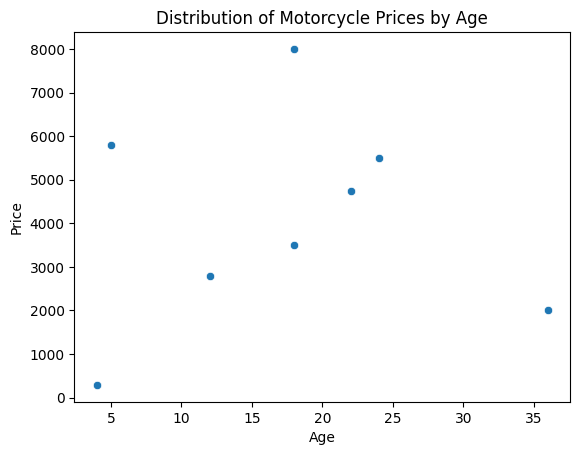

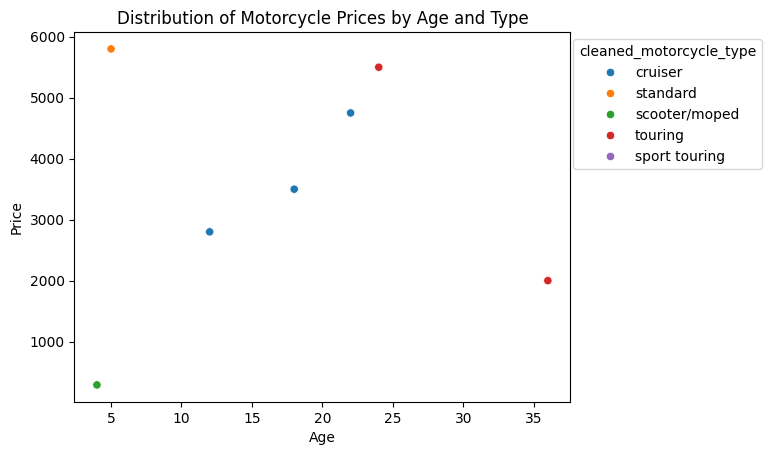

In [126]:
motorcycle_df["cleaned_year"] = pd.to_numeric(motorcycle_df["year"], errors="coerce")
motorcycle_df["age"] = 2025 - motorcycle_df["cleaned_year"]

x_var = "age"
y_var = "cleaned_price"
z_var = "cleaned_motorcycle_type"

fig = sns.scatterplot(data=motorcycle_df, x=x_var, y=y_var)
fig.set(title="Distribution of Motorcycle Prices by Age",
xlabel="Age", 
ylabel="Price")
plt.show()

fig = sns.scatterplot(data=motorcycle_df, x=x_var, y=y_var, hue=z_var)
fig.set(title="Distribution of Motorcycle Prices by Age and Type",
xlabel="Age", 
ylabel="Price")
sns.move_legend(fig, "upper right", bbox_to_anchor=(1.4, 1))


Aside from the 35 year-old outlier, the data points seem to exhibit a positive correlation between age and price. One possible explanation is that the older motorcycles may be in good condition, or classics that continue to gain value directly due to their age. We can explore this by also displaying motorcycles by their type. Cruisers seem to retain their value despite their age, while it can go either way for touring motorcycles. Scooter/mopeds and standard motorcycles are on vastly different sides of the price spectrum, but both seem to be quite new.

### What is the relationship between a motorcycle's milage and listing price?
Price can also thought to be impacted by a motorcycle's milage. The more a motorcycle has been driven/used, the more wear and tear it accumulates that decreases its value. We can explore this possible relationship with a scatterplot of our cleaned odometer and price variables:

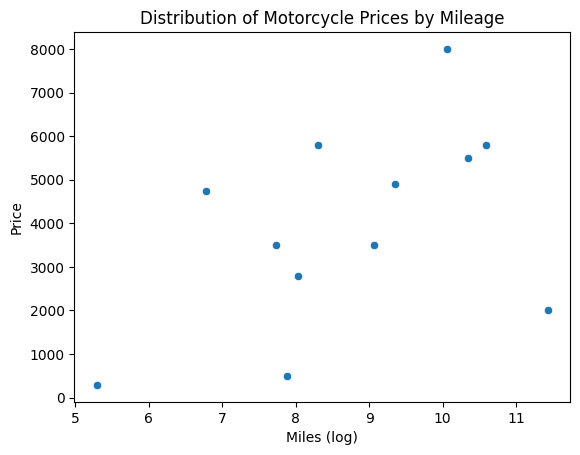

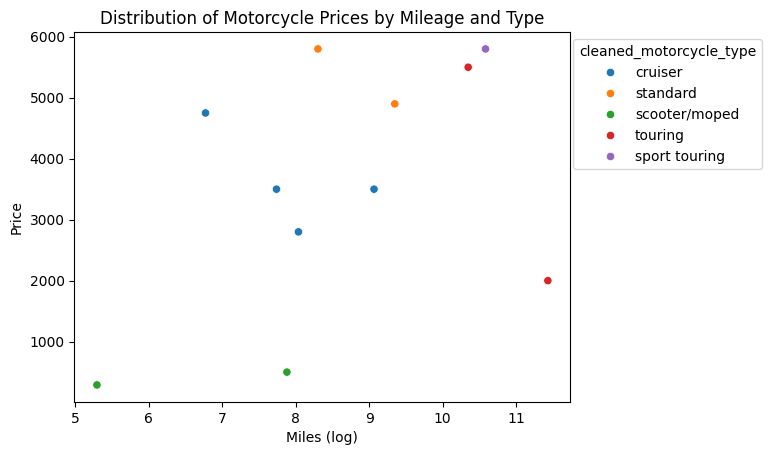

In [127]:
motorcycle_df["cleaned_odometer_reading"] = motorcycle_df["odometer_reading"].str.replace(",", "")
motorcycle_df["cleaned_odometer_reading"] = pd.to_numeric(motorcycle_df["cleaned_odometer_reading"], errors="coerce")
motorcycle_df["log_cleaned_odometer_reading"] = np.log(motorcycle_df["cleaned_odometer_reading"])

x_var = "log_cleaned_odometer_reading"
y_var = "cleaned_price"
z_var = "cleaned_motorcycle_type"

fig = sns.scatterplot(data=motorcycle_df, x=x_var, y=y_var)
fig.set(title="Distribution of Motorcycle Prices by Mileage",
xlabel="Miles (log)", 
ylabel="Price")
plt.show()

fig = sns.scatterplot(data=motorcycle_df, x=x_var, y=y_var, hue=z_var)
fig.set(title="Distribution of Motorcycle Prices by Mileage and Type",
xlabel="Miles (log)", 
ylabel="Price")
sns.move_legend(fig, "upper right", bbox_to_anchor=(1.4, 1))


Interestingly, we can see a positive correlation between the log of a motorcycle's odometer reading and its price. As a motorcycle is used more, its value increases. We can add a third dimension into our visualization, motorcycle type, to see that touring and sport touring motorcycles are the most used. Cruisers and standard motorcycles seem to have a smaller odometer reading, followed by scooter/mopeds.

### Which motorcycle brands remain high value, in spite of their milage/age?
In addition to a motorcycle's type, its brand also may play a significant role in its quality, reputation, and longevity, all of which factor in to its final value. We can craft two separate scatter plots, both colored by brand:

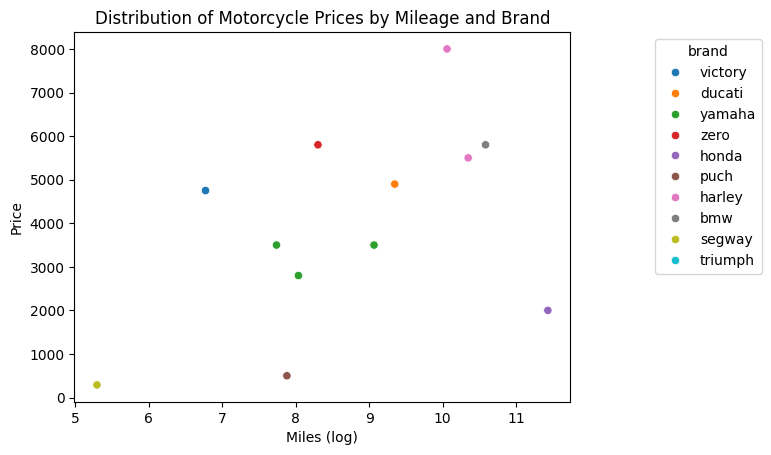

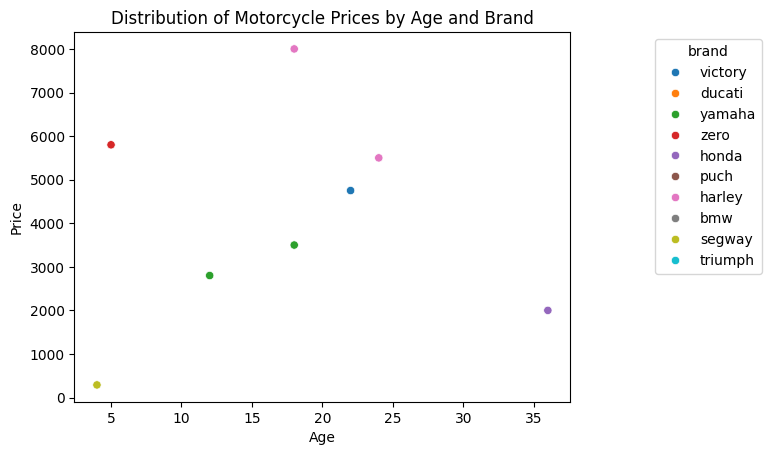

In [128]:
brands = ['honda', 
          'triumph',
          'yamaha',
          'bmw', 
          'harley', 
          'hd', 
          'victory', 
          'ducati', 
          'zero', 
          'puch', 
          'segway']

motorcycle_df["cleaned_make_model"] = motorcycle_df["make_model"].str.strip()
motorcycle_df["cleaned_make_model"] = motorcycle_df["cleaned_make_model"].str.lower()
# map them to the same brand
motorcycle_df["cleaned_make_model"] = motorcycle_df["cleaned_make_model"].str.replace("hd", "harley")

def find_brand(make_model):
    for brand in brands:
        if brand in make_model:
            return brand
    # no brand exists for this make_model string
    return np.nan

motorcycle_df["brand"] = motorcycle_df["cleaned_make_model"].apply(find_brand)

x_var = "log_cleaned_odometer_reading"
y_var = "cleaned_price"
z_var = "brand"

fig = sns.scatterplot(data=motorcycle_df, x=x_var, y=y_var, hue=z_var)
fig.set(title="Distribution of Motorcycle Prices by Mileage and Brand",
xlabel="Miles (log)", 
ylabel="Price")
sns.move_legend(fig, "upper right", bbox_to_anchor=(1.4, 1))
plt.show()

x_var = "age"

fig = sns.scatterplot(data=motorcycle_df, x=x_var, y=y_var, hue=z_var)
fig.set(title="Distribution of Motorcycle Prices by Age and Brand",
xlabel="Age", 
ylabel="Price")
sns.move_legend(fig, "upper right", bbox_to_anchor=(1.4, 1))


When visualizing motorcycle prices by mileage and brand, some clear clusters in our brands begin to appear. Yamaha motorcycles all seem to be at similar price points and mileges, along with Harleys, who are more used but also still retain high value. Honda motorcycles, while not the highest value, have great longevity. Lastly, segways remain low in all categories.

For motorcycle prices by age and brand, Honda continues to show its reliability, followed by Harley, Victory, and Yamaha. Based on these different visualizations, Harleys appear to strike the greatest balance in reliability, longevity, and value.